# Survivability Analysis

### Imports

In [18]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

### Define Paths

In [19]:
CWD = Path.cwd()
ROOT = CWD.parent if CWD.name.lower() == "notebooks" else CWD

DATA = ROOT / "data"
OUTPUTS = ROOT / "OUTPUTS"
TABLES = OUTPUTS / "tables"
FIGURES = OUTPUTS / "figures"

OUTPUTS.mkdir(parents=True, exist_ok=True)
TABLES.mkdir(parents=True, exist_ok=True)
FIGURES.mkdir(parents=True, exist_ok=True)

print("Python:", sys.version.split()[0])
print("PROCESSED:", PROCESSED)
print("FIGURES:", FIGURES)

Python: 3.11.9
PROCESSED: C:\Users\danci\Interconnection-Queue-Intelligence\Interconnection-Queue-Intelligence\data\processed
FIGURES: C:\Users\danci\Interconnection-Queue-Intelligence\Interconnection-Queue-Intelligence\OUTPUTS\figures


### Load Processed Files

In [20]:
public_path = PROCESSED / "public_queue_clean_combined.csv"
c15_path = PROCESSED / "cluster15_clean_combined.csv"
c14_path = PROCESSED / "cluster14_clean.csv"

for p in [public_path, c15_path, c14_path]:
    print(p.name, "exists:", p.exists())

public = pd.read_csv(public_path)
c15 = pd.read_csv(c15_path)
c14 = pd.read_csv(c14_path)

display(pd.DataFrame({
    "dataset": ["public", "cluster15", "cluster14"],
    "rows": [len(public), len(c15), len(c14)],
    "cols": [public.shape[1], c15.shape[1], c14.shape[1]],
}))

public_queue_clean_combined.csv exists: True
cluster15_clean_combined.csv exists: True
cluster14_clean.csv exists: True


,dataset,rows,cols
0,public,2290,24
1,cluster15,170,24
2,cluster14,363,14


### Prep: types, dates, technology buckets

In [21]:
def to_float(s):
    return pd.to_numeric(s, errors="coerce")

def to_dt(s):
    return pd.to_datetime(s, errors="coerce")

def norm_tech(x):
    if pd.isna(x): return ""
    s = str(x).strip().lower()
    if s == "": return ""
    if any(k in s for k in ["battery", "storage", "bess"]): return "storage"
    if any(k in s for k in ["solar", "pv", "photovoltaic"]): return "solar"
    if "wind" in s: return "wind"
    return str(x).strip()

def tech_group_row(row):
    t1 = norm_tech(row.get("tech_1",""))
    t2 = norm_tech(row.get("tech_2",""))
    t3 = norm_tech(row.get("tech_3",""))
    techs = sorted(set([t for t in [t1,t2,t3] if t != ""]))

    if not techs:
        return "unknown"
    if len(techs) >= 3:
        return "hybrid_multi"
    if techs == ["solar","storage"]:
        return "hybrid_solar_storage"
    if techs == ["solar","wind"]:
        return "hybrid_solar_wind"
    if techs == ["storage","wind"]:
        return "hybrid_storage_wind"
    if len(techs) == 1:
        return techs[0]
    return "hybrid_other"

def prep(df):
    df = df.copy()

    # ensure core columns exist
    if "mw_poi" in df.columns:
        df["mw_poi"] = to_float(df["mw_poi"])
    else:
        df["mw_poi"] = np.nan

    for t in ["tech_1","tech_2","tech_3"]:
        if t in df.columns:
            df[t] = df[t].map(norm_tech)
        else:
            df[t] = ""

    df["tech_group"] = df.apply(tech_group_row, axis=1)

    if "sheet_outcome" not in df.columns:
        df["sheet_outcome"] = "unknown"

    # parse date columns if present
    for d in ["date_queue","date_received","date_application","date_withdrawn","date_cod_current_or_actual","date_cod_requested"]:
        if d in df.columns:
            df[d] = to_dt(df[d])

    return df

public = prep(public)
c15 = prep(c15)
c14 = prep(c14)

display(Markdown("**Outcome counts:**"))
display(pd.DataFrame({
    "public": public["sheet_outcome"].value_counts().to_dict(),
    "cluster15": c15["sheet_outcome"].value_counts().to_dict(),
    "cluster14": c14["sheet_outcome"].value_counts().to_dict(),
}))

**Outcome counts:**

,public,cluster15,cluster14
withdrawn,1718.0,62.0,NaN
active,335.0,108.0,NaN
completed,237.0,NaN,NaN
intake_snapshot,NaN,NaN,363.0


# Analysis

## 1) Outcome Mix (MW-weighted): Public vs Cluster 15

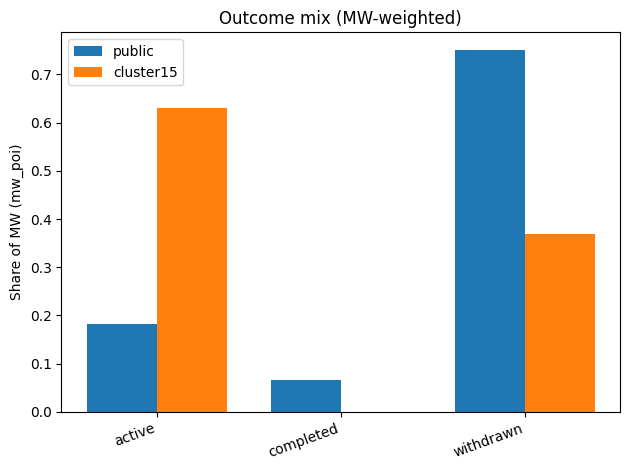

**Public MW by outcome:**

,mw_sum
sheet_outcome,
active,90191.1400
completed,32932.8874
withdrawn,369257.4747


**Cluster15 MW by outcome:**

,mw_sum
sheet_outcome,
active,37245.20
withdrawn,21767.51


In [22]:
def mw_share_by_outcome(df):
    g = df.groupby("sheet_outcome")["mw_poi"].sum(min_count=1)
    g = g.fillna(0)
    share = (g / g.sum()).fillna(0)
    return g, share

pub_mw, pub_share = mw_share_by_outcome(public)
c15_mw, c15_share = mw_share_by_outcome(c15)

outcomes = sorted(set(pub_share.index).union(set(c15_share.index)))
a = pub_share.reindex(outcomes).fillna(0).values
b = c15_share.reindex(outcomes).fillna(0).values

x = np.arange(len(outcomes))
w = 0.38

plt.figure()
plt.bar(x - w/2, a, width=w, label="public")
plt.bar(x + w/2, b, width=w, label="cluster15")
plt.xticks(x, outcomes, rotation=20, ha="right")
plt.ylabel("Share of MW (mw_poi)")
plt.title("Outcome mix (MW-weighted)")
plt.legend()
plt.tight_layout()
plt.savefig(FIGURES / "01_outcome_mix_mw_public_vs_cluster15.png", dpi=200)
plt.show()

display(Markdown("**Public MW by outcome:**")); display(pub_mw.to_frame("mw_sum"))
display(Markdown("**Cluster15 MW by outcome:**")); display(c15_mw.to_frame("mw_sum"))

## 2) Public Lifecycle Timing (Queue Age Distributions)

In [23]:
pub = public.copy()

# pick event date
pub["event_date"] = pd.NaT
if "date_withdrawn" in pub.columns:
    pub.loc[pub["sheet_outcome"].eq("withdrawn"), "event_date"] = pub.loc[pub["sheet_outcome"].eq("withdrawn"), "date_withdrawn"]
if "date_cod_current_or_actual" in pub.columns:
    pub.loc[pub["sheet_outcome"].eq("completed"), "event_date"] = pub.loc[pub["sheet_outcome"].eq("completed"), "date_cod_current_or_actual"]

# duration from queue date
if "date_queue" in pub.columns:
    pub["duration_days"] = (pub["event_date"] - pub["date_queue"]).dt.days
else:
    pub["duration_days"] = np.nan

timing = pub[pub["sheet_outcome"].isin(["withdrawn","completed"])].copy()
timing = timing[timing["duration_days"].notna() & (timing["duration_days"] >= 0)]

display(Markdown(f"**Rows with usable timing:** {len(timing)}"))

**Rows with usable timing:** 1901

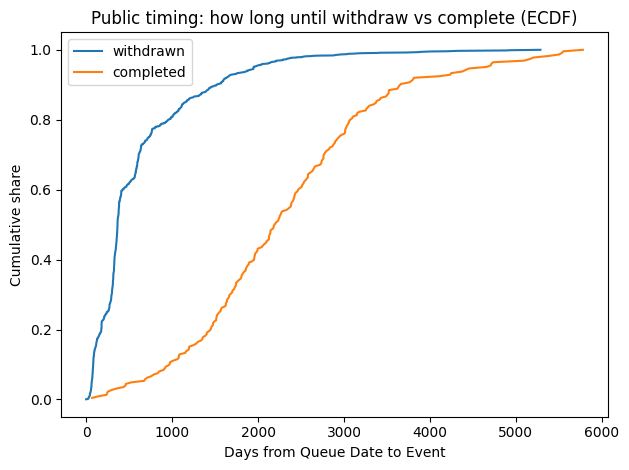

In [24]:
def ecdf(vals):
    v = np.sort(np.array(vals))
    y = np.arange(1, len(v)+1) / len(v)
    return v, y

plt.figure()
for outcome in ["withdrawn","completed"]:
    vals = timing.loc[timing["sheet_outcome"].eq(outcome), "duration_days"].values
    if len(vals) < 5:
        continue
    x, y = ecdf(vals)
    plt.plot(x, y, label=outcome)

plt.xlabel("Days from Queue Date to Event")
plt.ylabel("Cumulative share")
plt.title("Public timing: how long until withdraw vs complete (ECDF)")
plt.legend()
plt.tight_layout()
plt.savefig(FIGURES / "02_public_timing_ecdf_withdraw_vs_complete.png", dpi=200)
plt.show()

## 3) Intake Technology Mix (MW-weighted)

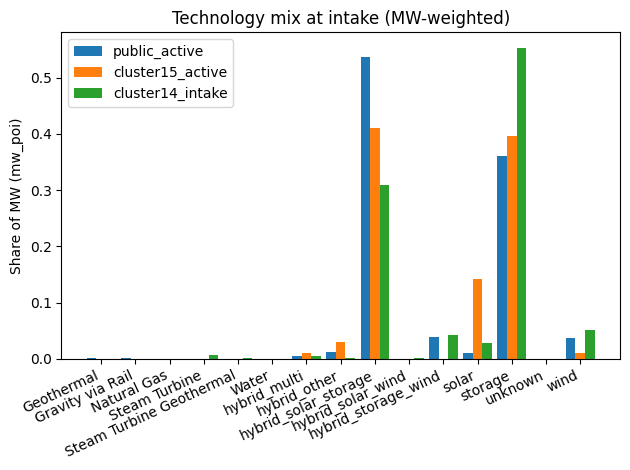

**Mix tables (MW share):**

,public_active,cluster15_active,cluster14_intake
tech_group,,,
Geothermal,0.000588,0.000000,0.000000
Gravity via Rail,0.000488,0.000000,0.000000
Natural Gas,0.000388,0.000000,0.000000
Steam Turbine,0.000000,0.000000,0.006963
Steam Turbine Geothermal,0.000000,0.000000,0.000500
Water,0.000055,0.000000,0.000000
hybrid_multi,0.004435,0.010740,0.004717
hybrid_other,0.011200,0.029507,0.001604
hybrid_solar_storage,0.537326,0.410791,0.309901


In [25]:
public_active = public[public["sheet_outcome"].eq("active")].copy()
c15_active = c15[c15["sheet_outcome"].eq("active")].copy()
c14_intake = c14.copy()  # already intake_snapshot

def tech_mix(df):
    g = df.groupby("tech_group")["mw_poi"].sum(min_count=1).fillna(0)
    share = (g / g.sum()).fillna(0)
    return share.sort_values(ascending=False)

mix_pub = tech_mix(public_active)
mix_15 = tech_mix(c15_active)
mix_14 = tech_mix(c14_intake)

cats = sorted(set(mix_pub.index).union(mix_15.index).union(mix_14.index))
a = mix_pub.reindex(cats).fillna(0).values
b = mix_15.reindex(cats).fillna(0).values
c = mix_14.reindex(cats).fillna(0).values

x = np.arange(len(cats))
w = 0.28

plt.figure()
plt.bar(x - w, a, width=w, label="public_active")
plt.bar(x, b, width=w, label="cluster15_active")
plt.bar(x + w, c, width=w, label="cluster14_intake")
plt.xticks(x, cats, rotation=25, ha="right")
plt.ylabel("Share of MW (mw_poi)")
plt.title("Technology mix at intake (MW-weighted)")
plt.legend()
plt.tight_layout()
plt.savefig(FIGURES / "03_intake_tech_mix_mw.png", dpi=200)
plt.show()

display(Markdown("**Mix tables (MW share):**"))
display(pd.DataFrame({
    "public_active": mix_pub,
    "cluster15_active": mix_15,
    "cluster14_intake": mix_14
}).fillna(0))

## 4) Withdrawal Signal by Technology (MW-based)

In [26]:
# Public: real resolved comparator = withdrawn/(withdrawn+completed) using MW
pub_resolved = public[public["sheet_outcome"].isin(["withdrawn","completed"])].copy()
pub_piv = pub_resolved.pivot_table(index="tech_group", columns="sheet_outcome", values="mw_poi", aggfunc="sum", fill_value=0)

if "withdrawn" not in pub_piv.columns: pub_piv["withdrawn"] = 0
if "completed" not in pub_piv.columns: pub_piv["completed"] = 0

pub_piv["public_withdraw_share_resolved_mw"] = pub_piv["withdrawn"] / (pub_piv["withdrawn"] + pub_piv["completed"]).replace(0, np.nan)

# Cluster15: signal comparator = withdrawn/(withdrawn+active) using MW
c15_piv = c15.pivot_table(index="tech_group", columns="sheet_outcome", values="mw_poi", aggfunc="sum", fill_value=0)
if "withdrawn" not in c15_piv.columns: c15_piv["withdrawn"] = 0
if "active" not in c15_piv.columns: c15_piv["active"] = 0

c15_piv["cluster15_withdraw_share_total_mw"] = c15_piv["withdrawn"] / (c15_piv["withdrawn"] + c15_piv["active"]).replace(0, np.nan)

# Combine into a single table
techs = sorted(set(pub_piv.index).union(set(c15_piv.index)))
tab = pd.DataFrame(index=techs)
tab["public_withdraw_share_resolved_mw"] = pub_piv.reindex(techs)["public_withdraw_share_resolved_mw"]
tab["cluster15_withdraw_share_total_mw"] = c15_piv.reindex(techs)["cluster15_withdraw_share_total_mw"]
tab = tab.fillna(0).sort_values("public_withdraw_share_resolved_mw", ascending=False)

display(tab)

,public_withdraw_share_resolved_mw,cluster15_withdraw_share_total_mw
Flywheel,1.000000,0.000000
hybrid_solar_wind,1.000000,0.000000
hybrid_multi,1.000000,0.000000
hybrid_storage_wind,1.000000,0.000000
Geothermal,0.996505,0.000000
Water,0.992657,0.000000
wind,0.940162,0.000000
storage,0.937857,0.457624
solar,0.934290,0.131670
hybrid_other,0.899229,0.333535


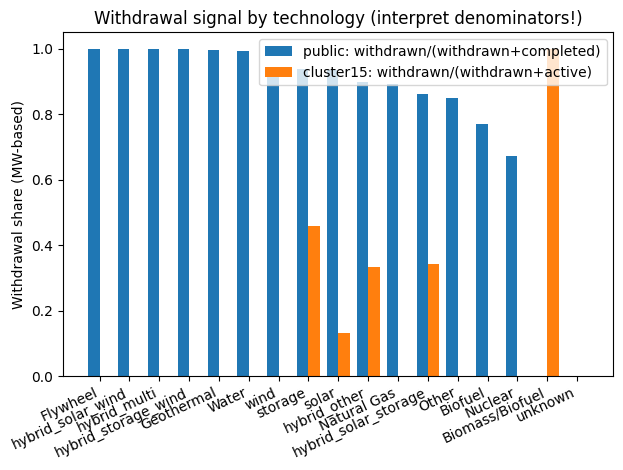

In [27]:
techs = tab.index.tolist()
a = tab["public_withdraw_share_resolved_mw"].values
b = tab["cluster15_withdraw_share_total_mw"].values

x = np.arange(len(techs))
w = 0.38

plt.figure()
plt.bar(x - w/2, a, width=w, label="public: withdrawn/(withdrawn+completed)")
plt.bar(x + w/2, b, width=w, label="cluster15: withdrawn/(withdrawn+active)")
plt.xticks(x, techs, rotation=25, ha="right")
plt.ylabel("Withdrawal share (MW-based)")
plt.title("Withdrawal signal by technology (interpret denominators!)")
plt.legend()
plt.tight_layout()
plt.savefig(FIGURES / "04_withdrawal_signal_by_tech.png", dpi=200)
plt.show()

## 5) Where MW is Concentrating (Top PTOs)

In [ ]:
def top_pto(df, label, top_n=12):
    if "pto" not in df.columns:
        return pd.DataFrame(columns=["pto","mw_sum","label"])
    g = df.groupby("pto")["mw_poi"].sum(min_count=1).fillna(0).sort_values(ascending=False).head(top_n)
    out = g.rename("mw_sum").to_frame().reset_index()
    out["label"] = label
    return out

t_pub = top_pto(public_active, "public_active", 12)
t_15 = top_pto(c15_active, "cluster15_active", 12)
t_14 = top_pto(c14_intake, "cluster14_intake", 12)

union = pd.concat([t_pub, t_15, t_14], ignore_index=True)
ptos = union.groupby("pto")["mw_sum"].sum().sort_values(ascending=False).head(12).index.tolist()

def series(label):
    s = union[union["label"].eq(label)].set_index("pto")["mw_sum"]
    return s.reindex(ptos).fillna(0).values

a = series("public_active")
b = series("cluster15_active")
c = series("cluster14_intake")

x = np.arange(len(ptos))
w = 0.28

plt.figure()
plt.bar(x - w, a, width=w, label="public_active")
plt.bar(x, b, width=w, label="cluster15_active")
plt.bar(x + w, c, width=w, label="cluster14_intake")
plt.xticks(x, ptos, rotation=30, ha="right")
plt.ylabel("MW (mw_poi)")
plt.title("Top PTO concentration (MW)")
plt.legend()
plt.tight_layout()
plt.savefig(FIGURES / "05_top_pto_concentration_mw.png", dpi=200)
plt.show()

display(union.sort_values(["label","mw_sum"], ascending=[True, False]).head(30))

### Save Summary Tables

In [ ]:
tab.to_csv(TABLES / "withdrawal_signal_by_tech.csv", index=False)

pd.DataFrame({
    "public_mw": pub_mw,
    "public_share": pub_share
}).to_csv(TABLES / "public_outcome_mw.csv", index=False)

pd.DataFrame({
    "cluster15_mw": c15_mw,
    "cluster15_share": c15_share
}).to_csv(TABLES / "cluster15_outcome_mw.csv", index=False)

pd.DataFrame({
    "public_active": mix_pub,
    "cluster15_active": mix_15,
    "cluster14_intake": mix_14
}).fillna(0).to_csv(TABLES / "intake_tech_mix_mw.csv", index=False)

union.to_csv(TABLES / "top_pto_mw_union.csv", index=False)

display(
    Markdown(
        "**Saved tables → `OUTPUTS/tables/` and figures → `OUTPUTS/figures/`**"
    )
)